In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import brewer2mpl
import colorsys
import math
import dendropy as dp
import json

from datetime import datetime
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Levenshtein import distance
from itertools import combinations, product, permutations
from time import time
from __future__ import division
from collections import Counter, defaultdict
from copy import deepcopy
from random import shuffle, choice, sample
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson, binom
from scipy.misc import comb
from IPython.display import Math
from networkx.readwrite import json_graph 

%matplotlib inline

In [2]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')
G.edges(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 'A/green-winged teal/Interior Alaska/6MP1077/2006',
 {'edge_type': 'full_complement',
  'pwi': 7.7231860000000001,
  'segments': {1: 0.99085800000000002,
   2: 0.88994799999999996,
   3: 0.90987300000000004,
   4: 0.99942500000000001,
   5: 0.93408000000000002,
   6: 1.0,
   7: 0.99900199999999995,
   8: 1.0}})

In [3]:
# Identify the reassortants.
reassortant_viruses = []
for source, sink, data in G.edges(data=True):
    if data['edge_type'] == 'reassortant' and sink not in reassortant_viruses:
        reassortant_viruses.append(sink)
        
print(len(reassortant_viruses))

2163


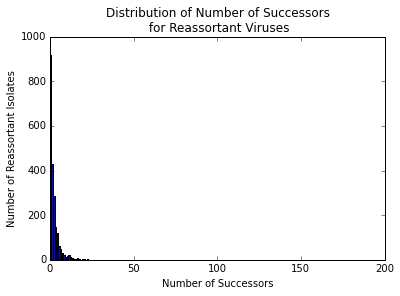

In [4]:
# Distribution of # of descendents of reassortant viruses.
reassortant_successor_counts = []
for virus in reassortant_viruses:
#     print len(G.successors(virus))
    reassortant_successor_counts.append(len(G.successors(virus)))

plt.bar(Counter(reassortant_successor_counts).keys(), Counter(reassortant_successor_counts).values())
plt.xlabel('Number of Successors')
plt.ylabel('Number of Reassortant Isolates')
plt.title('Distribution of Number of Successors\n for Reassortant Viruses')

In [5]:
Counter(reassortant_successor_counts)

Counter({0: 919, 1: 429, 2: 288, 3: 146, 4: 118, 5: 60, 6: 50, 7: 30, 11: 21, 8: 20, 10: 17, 9: 13, 12: 11, 13: 10, 16: 6, 15: 5, 14: 3, 17: 2, 19: 2, 20: 2, 22: 2, 18: 1, 24: 1, 25: 1, 26: 1, 30: 1, 45: 1, 187: 1, 73: 1, 74: 1})

In [12]:
# The large outliers are the interesting ones.
vois = [v for v in reassortant_viruses if len(G.successors(v)) == 73]
vois

['A/New York/3257/2009']

In [13]:
for v in vois:
    print(G.successors(v))

['A/Nanchang/8011/2009', 'A/swine/Hong Kong/3065/2010', 'A/Northern Ireland/94940020/2009', 'A/Argentina/9384/2009', 'A/Gunma/262/2009', 'A/swine/Heilongjiang/105/2009', 'A/New York/3611/2009', 'A/New York/3571/2009', 'A/swine/Guangdong/NS2801/2010', 'A/swine/Shandong/361/2010', 'A/Bethesda/SP506/2009', 'A/Argentina/9180/2009', 'A/swine/Shandong/327/2010', 'A/New York/3235/2009', 'A/New York/06/2009', 'A/Argentina/7967/2009', 'A/swine/Jangsu/504/2010', 'A/swine/Jangsu/49/2010', 'A/New York/3167/2009', 'A/Argentina/8994/2009', 'A/New York/3194/2009', 'A/New York/3568/2009', 'A/Argentina/9333/2009', 'A/Argentina/8989/2009', 'A/Lima/WRAIR1696P/2009', 'A/swine/Jangsu/46/2010', 'A/swine/Shandong/94/2010', 'A/Reunion/2378-1-M1E/2009', 'A/Argentina/7980/2009', 'A/Northern Ireland/94940023/2009', 'A/New York/3265/2009', 'A/Argentina/8019/2009', 'A/Argentina/8574/2009', 'A/swine/Jangsu/285/2010', 'A/Shanghai/P1/2009', 'A/Piura/WRAIR1694P/2009', 'A/Nanchang/8002/2009', 'A/swine/Jangsu/434/2010',

In [14]:
def get_subtypes(graph):
    subtypes = set()
    for node, data in graph.nodes(data=True):
        subtypes.add(data['subtype'])
        
    return subtypes

In [15]:
subgraphs = [g for g in nx.connected_component_subgraphs(G.to_undirected())]
for g in subgraphs:
    print(get_subtypes(g))
    print(len(g.nodes()))

set(['H7N6', 'H10N8', 'H10N9', 'H10N1', 'H10N2', 'H10N3', 'H10N4', 'H10N5', 'H10N6', 'H10N7', 'H2N4', 'H2N5', 'H2N6', 'H2N7', 'H2N1', 'H2N2', 'H2N3', 'H2N8', 'H2N9', 'H8N8', 'H6N4', 'H8N4', 'H8N2', 'H8N1', 'H6N6', 'Mixed', 'H9N8', 'H5N7', 'H4N3', 'mixed', 'H5N4', 'H4N6', 'H11N7', 'H5N2', 'H3N9', 'H3N8', 'H12N9', 'H4N4', 'H3N1', 'H3N3', 'H3N2', 'H3N5', 'H3N7', 'H3N6', 'H4N8', 'H4N9', 'H5N9', 'H5N8', 'H4N2', 'H5N6', 'H5N5', 'H4N1', 'H5N3', 'H4N7', 'H5N1', 'H4N5', 'H6N8', 'H6N9', 'H7N9', 'H7N8', 'H7N5', 'H6N1', 'H6N2', 'H6N3', 'H7N1', 'H6N5', 'H7N3', 'H7N2', 'H12N6', 'H12N7', 'H7N4', 'H7N7', 'H1N9', 'H1N8', 'H1N3', 'H1N2', 'H1N1', 'H1N7', 'H1N6', 'H1N5', 'H1N4', 'H9N3', 'H9N2', 'H9N1', 'H9N7', 'H9N6', 'H9N5', 'H9N9', 'H6N7', 'H12N8', 'H11N6', 'H11N1', 'H11N3', 'H11N2', 'H12N2', 'H12N3', 'H12N1', 'H11N9', 'H11N8', 'H12N4', 'H12N5', 'H16N3', 'H15N9', 'H14N6', 'H15N4', 'H14N2', 'H13N6', 'H13N2', 'H13N9', 'H13N8'])
16508
set(['H3N8'])
56
set(['H6N1'])
1
set(['H10N2'])
1
set(['H3N8'])
1
set(['

In [26]:
# When did do the reassortant viruses show up in each of the subgraphs?
unlinkedG = nx.read_gpickle('20141103 All IRD Parallel Transmission Graph Non-Same Subtypes Removed.pkl')

def get_subgraph_with_node(subgraph_list, node):
    for g in subgraph_list:
        if node in g.nodes():
            return g

        
def get_node_time_range(graph):
    times = [d['collection_date'] for n, d in graph.nodes(data=True)]
    
    times = sorted(times)
    
    return times

def get_graph_subtypes(graph):
    subtypes_represented = set()
    
    for node, data in graph.nodes(data=True):
        subtypes_represented.add(data['subtype'])
        
    return subtypes_represented
    
num_nodes_data = list()
time_span_data = list()
    
for i, g in enumerate(nx.connected_component_subgraphs(unlinkedG.to_undirected())):
    times = get_node_time_range(g)
    earliest_time = min(times)
    latest_time = max(times)
    time_span = (latest_time - earliest_time).days
    subtypes_represented = get_graph_subtypes(g)
    num_nodes = len(g.nodes())
    
    num_nodes_data.append(num_nodes)
    time_span_data.append(time_span)

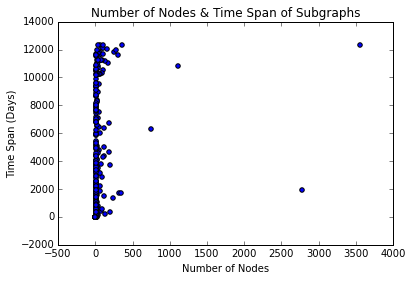

In [28]:
plt.scatter(num_nodes_data, time_span_data)
plt.xlabel('Number of Nodes')
plt.ylabel('Time Span (Days)')
plt.title('Number of Nodes & Time Span of Subgraphs')